#  **ICT303 - Assignment 2**

**Your name: David Long**

**Student ID: 34252947**

**Email: david.wip.long@gmail.com**

In this assignment, you will build and train a deep learning model for solving a problem of your choice.


You are required to:
- Think of a practical problem that you would like to solve. The problem can be related, but not limted to, object detection and recognition from images, text analysis, speech analysis, image unpainting, converting images to artistic painting, action recognition (from images or videos), image to text (i.e., generating textual description for images or videos), or texrt to image (generating images from text) etc.,
- Find an appropriate data set to train and test the model you will develop. Note that the dataset should contain enough data (with groundtruth labels) so that when used for training, the model can generalize well to unseen data.
- Design a neural network that will solve the problem
- Train the neural network on your training data and then evaluate its performance on test data
- Analyze the performance of the network you developed and discuss its limitations.

**What to submit:**
- A colab notebook that describes:
 - The problem you would like to solve **[10 Marks]**
 - The dataset that you will use to train and test the deep learning model that you will develop **[10 marks]**
 - A diagram that describes the architecture of the neural network that you developed **[10 marks]**
 - Performance curves - this is includes the loss curves as well as the accuracy **[10 marks]**
 - A discussion, analysis and justification of the different choices you made and their effect on the performance **[15 marks]**
 - A discussion, analysis of the limitations of your method. You can also show failure cases and try to understand why did it fail on these cases **[15 marks]**

- Source code that runs - this includes both code for training and testing **[30 marks]**

You also need to submit the dataset you used for training and testing, or alternatively provide the code that downloads the data.

Make sure you reference all sources from which you took information.

You are allowed to use existing neural networks (not required to implement them from scratch). But, you must customize the architecture to the problem you want to solve.

**Where to find datasets?**
- [Kaggle competition](https://www.kaggle.com/c/dog-breed-identification) is a good source.
- You can also look at this [wikipedia site[(https://en.wikipedia.org/wiki/List_of_datasets_for_machine-learning_research)

If you are thinking of a specific problem and were unable to find a suitable dataset, please talk to me during the lecture or lab and we will search together.

**Recommended timeline**
- Week 1 of Assignement release: identify 2 or 3 problems of interest, a find dataset for each of the problem and try to understand how to load the data and how it is organised. Discuss it with the UC during the lab session or via email.
- Week 2:
 - Make sure your dataloader works proply and you are able to load the data and structure it in a way that neural networks can use them.
 - Design your network architecture
- Week 3: Network architecture implemented and training and testing done. Evaluate the performance
- Week 4: Finetune the network architecture and the hyperparameters to improve the performance. Write the report for submission.

It is highly recommended that you follow this timeline. The earlier you start training and testing, the more time you will have to finetune your solution and achieve a better performance.


#  **The Problem**

I have decided to attempt to create a model which is capable of translating English to Bahasa Indonesia. I have the least experience with sequential data for deep learning, and have chosen the translation task for these langauges because my nationality is mixed with the two, so I personally find it interesting. Effective language translation requires a complex model to capture contextual information.
I used the following steps to structure this project around the problem:
 1. Find an appropriate, labelled dataset
 3. Filter out noisy/unwanted data
 4. Tokenize the data
 5. Create a vocabulary for both languages (of tokens)
 6. Create tokenized versions of the dataset
 7. Train the model based on sequences of input tokens and sequences of labels
    
Each step is listed above is important and can greatly affect the performance of the model in training and inference.
Since the languages have different structures, an english sentence may have a different number of tokens to an Indonesian sentence. For example: "My name is David" = "Nama Saya David" or "Namaku David". This example also demonstrates synonyms, where a sentence can be written in numerous ways (in either language) which still share the same meaning. A suitable dataset which contains labelled examples of various synonyms is necessary for this task, as well as a complex-enough model to generate proper translations.

The [dataset](https://huggingface.co/datasets/kaitchup/opus-Indonesian-to-English) can be downloaded using [download_dataset.py](./download_dataset.py)
The entire dataset download and preprocessing can be ran using the [setup.sh](./setup.sh) bash script. The current working directory must be in src/. for this script to work properly.

**However, running this script replaces the [vocab.json](./data/vocab.json) file. The order of the tokens in this file is coupled with the indices learned by the model(s) in training.**

Here is a summary of what the setup-steps do.

**1. python3 ./download_dataset.py**
- Downloads the original dataset.
 
**2. python3 ./clean_dataset.py**
- Filters out the unclean data samples and saves cleaned versions.

**3. python3 ./generate_vocab.py**
- Tokenizes the dataset and saves maps, converting tokens to indices, for both languagues.
*The order of this script can vary, since I did not include sorting. A trained model is tied to its' original vocab order.*

**4. python3 ./encode_dataset.py**
- Creates new versions of the clean dataset, using the tokens found from the previous step.

#  **Setup**
To setup the program, it is first necessary to ensure the working diretory in src/.
The setup.sh script can be ran to setup the necessary dependencies of the project.

[Warning - the "!rm" line deletes all previous setups]

[Warning #2 - the script output is very long for notebooks, and should probably have scrolling enabled]

In [1]:
from config import *

from collections import defaultdict

import datasets

from dataset.ENGtoID import ENGtoID
from models.seq2seq_lstm import LSTMEncoder, LSTMDecoder, Seq2SeqLSTM
from trainers.trainer import Trainer
from utils.preprocessing import load_vocab_from_disk, tokenize_english
from utils.coder import Coder

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from PIL.Image import Image

import tensorboard

%load_ext tensorboard

In [2]:
!rm -r checkpoints data runs

In [3]:
#!rm -r checkpoints data runs
!ls
!pwd
!./setup.sh

'ICT303 - Assignment 2.ipynb'   encode_dataset.py       test_valid.py
 __pycache__		        generate_vocab.py       train_model.py
 assets			        models		        train_seq2seq_lstm.py
 clean_dataset.py	        setup.sh	        trainers
 config.py		        test_dataset.py         utils
 dataset		        test_preprocessing.py
 download_dataset.py	        test_trainer.py
/root/ict303-assignment2/src
Saving the dataset (1/1 shards): 100%|█| 989529/989529 [00:00<00:00, 5543455.91 
[Download] Saved: ./data/train.hf
Saving the dataset (1/1 shards): 100%|█| 2000/2000 [00:00<00:00, 934768.00 examp
[Download] Saved: ./data/valid.hf
[Download] Finished.
[Clean] Loaded 989529 raw train samples.
NOT CLEAN: hmm. hmm. _
NOT CLEAN: telurku ini tidak busuk. [chuckles]: not my bad eggs.
NOT CLEAN: penggunaan: %s [ opsi ] [ <interval> [ <hitungan> ] ] [ ] usage: %s [ options ] [ <interval> [ <count> ] ] [ <datafile> ]
NOT CLEAN: yang seharusnya universitas publik dipaksa untuk beradaptasi dengan imper

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[Vocab] Loaded 943036 clean train samples.
100%|███████████████████████████████| 943036/943036 [00:08<00:00, 107869.07it/s]
[Vocab] Found 136818 Indonesian tokens.
[Vocab] Found 115736 English tokens.
[Vocab] Saved vocab to: ./data/vocab.json
[Encode] Loaded 943036 clean train samples.
100%|████████████████████████████████| 943036/943036 [00:13<00:00, 71293.55it/s]
Saving the dataset (1/1 shards): 100%|█| 943036/943036 [00:00<00:00, 3101210.23 
[Encode] Saved: ./data/train_encoded.hf
[Encode] Loaded 1873 raw valid samples.
100%|████████████████████████████████████| 1873/1873 [00:00<00:00, 80584.40it/s]
Saving the dataset (1/1 shards): 100%|█| 1873/1873 [00:00<00:00, 712233.13 examp
[Encode] Saved: ./data/valid_encoded.hf
[Encode] Finished.


# **Tokenizer and Preprocessing**

During the setup process, the [download_dataset.py](./download_dataset.py) script fetches and downloads the dataset from Hugging Face. The dataset is saved in /data directory.

Then the [clean_dataset.py](./clean_dataset.py) script reads through the raw data and filters out unwanted entries. This script uses regex pattern matching to determine this. It then saves a new clean dataset for both train and valid in the /data directory.

The [generate_vocab.py](./generate_vocab.py) script then goes through every entry in train dataset, and creates a vocabulary for both English and Indonesian. It does this by tokenizing each entry in the train set. For this project I decided to implement a simple tokenizer, from scratch, instead of using an established one, since I would know the specifics of how it work exactly. Knowing the implementations thoroughly helps me diagnose/analyse weaknesses in the model performance and training intuitively. As the tokenizer reads tokens from the train set, it saves them to a token set, with no duplicates. Every token for both langauges are stored in [vocab.json](./data/vocab.json).

After the vocabulary is created for the train set, the dataset goes through a final preprocessing stage where it is index-encoded. To sum up what [encode_dataset.py](./encode_dataset.py) does, it goes through each entry in the dataset and tokenizes them. It then converts the entry into an array of indices, where each index points to the token's index in the vocabulary for that language. Additionally, an \<EOS\> token is appended to the end of each entry. The \<EOS\> along with other data semantic tokens are added to the vocabulary manually in the previous step, to ensure they have an existing index to represent them. The new 'encoded' dataset is saved separately, but in /data like the others. **Important note:** order of the tokens in the vocabulary does change and is not sorted for each time these setup steps are processed. This means when a model is being trained, the vocabulary and the dataset should not be reset.

Below is an example of what a data entry looks like after preprocessing.

In [2]:
# load the encoded example
encoded_example = datasets.load_from_disk(TRAIN_ENCODED_PATH)["text"][5]
print(encoded_example)

{'eng': [41107, 84898, 62292, 37281, 29140, 87129, 110193, 27799, 82019, 1], 'id': [40001, 85683, 104106, 17892, 12685, 96825, 1]}


```
-- values may not match above --
{'eng': [31852, 95738, 87251, 50861, 16639, 12296, 36826, 113736, 36153, 1], 'id': [52280, 98559, 81350, 132670, 132442, 43015, 1]}

```
The sample above shows a map where "eng" and "id" contain some different values in lists. These values are token indices stored in the vocabulary.

Below shows an example on how to load the vocabulary, as well as instanciate a coder/encoder class for each language.

In [7]:
# load the vocabulary
vocab = load_vocab_from_disk(VOCAB_PATH)
    
# create a Coder instance
coder_id = Coder(vocab["id"])
coder_eng = Coder(vocab["eng"])

This is how to use the coder class to decode the indices back to their original tokens. These classes are used for both encoding and decoding.

In [4]:
decoded_example_id = coder_id.decode(encoded_example["id"])
decoded_example_eng = coder_eng.decode(encoded_example["eng"])

print(decoded_example_id, decoded_example_eng)

['Kita', 'mulai', 'dengan', 'cambuk', 'pendek', '.', '<EOS>'] ['We', "'", 'll', 'start', 'with', 'the', 'riding', 'crop', '.', '<EOS>']


Above output (**from my session, possibly affected by random seed**)
```
['<SOS>', 'Kita', 'mulai', 'dengan', 'cambuk', 'pendek', '.', '<EOS>']
['<SOS>', 'We', "'", 'll', 'start', 'with', 'the', 'riding', 'crop', '.', '<EOS>']
```
The output above shows the encoded example from the encoded train set can be decoded back to their original tokens. This also shows the nature of the tokneizer. Full stops, apostrophes and \<EOS\> are present as seaprate tokens. The above example (at least when I am running this notebook) shows a basic translation, which also has some insight into how the model may work. In Indonesian "cambuk pendek" translates to short whip, however in English it is known as a "riding crop". The words by themselves do not translate to each other, and so for an effective translation model, contextual information needs to be captured for accurate translations. The model I have chosen with (Sequence to Sequence LSTM Encoder-Decoder) is a well known architecture which is capable of capturing contextual information (more about this in the model section).

# **Dataset and Dataloader**

Now that the dataset and vocabulary is setup, the following code sets up the dataloaders where the trainer is able to use them for training/validation.

For convinience, I have implemented a class called ENGtoID, which extends the torch dataset class. This class contains basic functions to load an item from the dataset, in the format which the torch dataloader classes can use. It also contains a static method called collate_fn. This function adds padding to the batches.

This dataset after cleaning/filtering contains roughly 1 million entries, which all contain an english sentence and an Indonesian sentence. In order to train efficiently for this project with limited time, it is worth batching the data. The batching also allows the model to 'capture' the error across the entire batch and improve on it, and is also computationally more efficient as accelerated hardware can utilise their large memory to store large tensors and perform floating point operations on them together, as oppose to loading and unloading in individual entries each time. 
*Note: for this task, I have utilised [vast.ai](https://vast.ai) to rent an RTX 4090 in order to train this model.*

Since the model is prefferably trained on batches, the batches need to be padded correctly. This is a sequence to sequence model (n to m), and the input sequence often differs in length to the output. For batching to be used, the sequences must be padded so that the input and output tensors are shaped to fit the longest sequence, and padding for the rest of the sequences. Torch allows a simple way to do it using pad_sequence as seen in [ENGtoID.py](./dataset/ENGtoID.py). Torch also supports ignore_idx parameters for cross entropy loss, which is utilised in [seq2seq_lstm.py](./models/seq2seq_lstm.py). This means the loss function ignores the padding index. The padding index is defined in [config.py](./config.py) as 0.

To use the collate_fn method to apply padding, all that is required is passing it into dataloader's collate_fn parameter.

This is how to create create the torch dataloaders for the dataset.
```
hyper_params = {
    "bs": 128,
    "lr": 0.001,
    "epochs": 5
}

dataset_train = ENGtoID(False)
dataset_valid = ENGtoID(True)

dataloader_train = DataLoader(dataset=dataset_train, batch_size=bs, shuffle=True, collate_fn=ENGtoID.collate_fn)
dataloader_valid = DataLoader(dataset=dataset_valid, batch_size=bs, shuffle=False, collate_fn=ENGtoID.collate_fn)
```

Note: I have not defined them in the code yet to avoid duplication. They will be defined properly in the training section.

# **The Model**

For this task, I have decided to implement a Sequence-To-Sequence Encoder-Decoder model which uses LSTM cells. Below is a visual representation of what themodel is, and is heavily based on a commonly-used, standard implementation of using LSTM cells and an embedding layer for sequence to sequence modelling.

**LSTM Cell**
The model I have configured has a hidden state size of 512 and a single layer. At each time step, the hidden state in the LSTM has a dimensional size of 512. Intuitively, this should allow for complex contextual learning, as each hidden state has many learned features to carry onto the next state. I chose a single layer because I thought 512 would be high enough to get notable translation performance for this task, and did not end up requiring an additional layer which would cost significantly more compute. Below is a diagram I created, but it is the same as many diagrams that already exist.
![image](./assets/lstm_cell_diagram.png)

**Encoder-Decoder**
The model's forward-pass uses the following sequence (input output sequence):
1. Embed raw input into embedded vector space
2. Pass embedded vector into the LSTM cells, recursively processing at each timestep
3. Pass LSTM output's cell and hidden state into the decoder
4. Decode the state using embedding (it learns to decode) on the previous state
5. Run the LSTM blocks on the decoded state to capture embedded contextual information
6. Capture predictions (logits) for each timestep

The encoder and decoder both use an embedding layer. This layer converts their input vectors into a learned vector space. This vector space should embed related words and should be able to 'capture' relative meaning of sequences. For example, though I find it impossible to visualise a 1000 dimensional vector space could hold data for words, where different contextual meanins are 'related' or 'nearby' in the vector space. Having a complex, high dimensional vector space should theoretically be able to manage distances between the 'meanings' of tokens.

![image](./assets/model_diagram.png)

During training, the model will adjust its' embedding weights for both the encoder and decoder. For this architecture, I have used the vocabulary size for the number of embeddings. The encoder embedding layer uses the English vocabulary size as its' dimensions, and the decoder's emebedding layer uses the Indonesian vocabulary size as the embedding layer. This allows the embedding layers to effectively capture all the different tokens, as each token is embedded in a 512 dimension vector space.
The decoder effectively reverses the process, as the decoder 'embeds' the encoders' output into a vetor space which the Indonesian tokens are embedded in. The decoder's LSTM cells learn to convert the embedded Indonesian tokens (predicted by the encoder) into their respective logits for output. These logits are used to make predictions and calculate the loss.

**Loss Function / Criterion**
The output of the model at each timestep is a tensor with 136818 logits for each timestep. This is the size of the Indonesian token vocabulary. With this output, it is possible to calculate the loss by using cross entropy loss, ignoring the padding for batches.

**Optimizer** For this model I have used the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer. I chose this optimizer as in the testing period of the model, [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) was much less stable. I believe Adam is a suitable option, due to its' behavior where it calculates the moving average of the gradients, and applies a decay factor to them. This results in stable learning without having to constantly adjust the learning rate during epochs (between 900k and 1m entries per epoch).

References:
[wikipedia-lstm](https://en.wikipedia.org/wiki/Long_short-term_memory) |
[torchdocs-lstm](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) |
[torchdocs-embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)

In [5]:
# load the vocab data (defined in config.py)
vocab_id = N_ID_TOKENS
vocab_eng = N_ENG_TOKENS

# load the dataset
dataset_train = ENGtoID(False)
dataset_valid = ENGtoID(True)

# define the model params
hidden_state_size = 512
layers = 1
max_inference_tokens = 128

# create the encoder and decoder
encoder = LSTMEncoder(vocab_eng, hidden_state_size, num_layers=layers)
decoder = LSTMDecoder(vocab_id, hidden_state_size, num_layers=layers)

# create the model
model = Seq2SeqLSTM("seq2seq_512_1", encoder, decoder, max_inference_tokens)

# initialise the model (custom behaviour, see model.py for details)
model.init(0.00)

# load the model if it exists on disk
model.load_model()

Loaded model checkpoint.


True

# **Training**

Training the model is simple using the [trainer](./trainers/trainer.py) class. This class has custom behaviour to run the model on a batch, calculate the loss, then optimize. It also saves model analytics, viewable using Tensorboard in ./runs, or in plot image files, showing the loss/accurate rate over time. The plot images are saved in ./checkpoints/{model_name}, as well as the model file itself its' saved losses/accuracies over time.

In [6]:
# setup trainer
trainer = Trainer(0, True)

The trainer.fit method uses the dataloaders defined earlier, as well as the model. 

For the first 3 epochs, I have decided to use a learning rate of 0.001, and a batch size of 128. On my local machine, the batch size and model size is far too large to compute using an RTX 2060 SUPER, so by renting an RTX 4090's compute from the cloud, I was able to more efficiently train the model with a higher batch size without compromising on the model's architecture by lowering the hidden state dimensions, for example.

During training, I monitored the performance by looking at the plot image as well as the output generated below. Every 100 or so batches, the plot is updated.

After every epoch, the model is processed on the valid set, which is saved onto a different plot. It was difficult to monitor the validation performance during training, since the number of train samples are so high, and the epochs take quite long. The loss is calculated simply using cross entropy loss, however the accuracy calculation required a few more steps.

**Accuracy** In order to calculate the accuracy on a batch the output batch must have max() applied across the logits' dimension for each class output. This leaves the highest value (best prediction) for the token. The targets tensor (y) is checked against the padding index (0) to create a padding mask. This mask leaves a matrix where padded values in the targets tensor are 0, and non padded values are 1. The predicted values matrix (which had .max() applied) are then compared against the targets matrix, but not where padding is applied, to calculate the accuracy. The accuracy is then converted to a percentage. This is not a sophisticated way to capture the effective accuracy of a translation task in general, but does work to provide insight into the model's performance during training/validation.

**Accuracy Metric** For this language translation task, simply calculating the number of matching tokens the model outputs is not a sophisticated way to understand its' accuracy. Many words have many appropriate synonyms, and a sentence can be written in many ways which still capture roughly the same meaning. It is difficult to define what equivalent-meaning words which are correct for any given context. (Not implemented) there are some proposed ways to gain better understanding into a language translator's accuracy. For example the [bleu score](https://en.wikipedia.org/wiki/BLEU) is a more advanced metric. This involves using reference words and n-grams.

**Teacher Forcing** During training, the model uses a slightly different forward-pass than its' validation counterpart. When an input tensor is passed into the model, along with a label (target) tensor, the model assumes that it is training, and uses the target tensor to help make more accurate predictions. 

The model uses the actual length of the target tensor when making predictions during training. This helps the model stay on-track, and learn more efficiently. If in an untrained state, and if the model did not know the length of the target tensors, it would likely spend much of its' time not ending sentences appropriately (by generating the \<EOS\> token). There are over 100k tokens it may generate, and would most likely waste a lot of time and computation trying to learn this during its' training, thus requiring significantly more epochs to learn.

Also, the model uses the actual target tensor as an input into the decoder. As it is making predictions, the decoder first takes the hidden state and cell state from encoder (which processed the input tensor). After making a initial prediction, it takes the target tensor at time t as an input, as well as its' previous hidden state and cell state. Using the actual y target instead of the token at x for the decoder is a more focused way to teach the model how to decode the embedded input.

**Hyper Parameters** For the training, I attempted the following hyper paramter 'schedule'
```
    {"bs": 128, "lr": 0.001, "epochs": 5, "teacher_forcing": 1.0},
    {"bs": 128, "lr": 0.0005, "epochs": 5, "teacher_forcing": 1.0},
    {"bs": 128, "lr": 0.0001, "epochs": 5, "teacher_forcing": 1.0},
    {"bs": 128, "lr": 0.00005, "epochs": 5, "teacher_forcing": 1.0},
    {"bs": 64, "lr": 0.00005, "epochs": 5, "teacher_forcing": 0.5},
    {"bs": 64, "lr": 0.0001, "epochs": 5, "teacher_forcing": 1.0}
```
The idea behind this is that the first 5 epochs at 0.001 learning rate with 100% teacher forcing is that the model should first learn basic mappings between words in the training set. This sequence is enough to get the model at above 65% accuracy on the training set.

The second sequence is a lower learning rate at 0.0005 and 5 epochs. The idea is that the model will slightly finetune its' learnings over many more epochs, potentially improving its' understanding of mapping different words in different contexts. This loop boosts the model's accuracy on the training set to above 75%.

The third sequence is the same as the previous, however with a lower learning rate. Over 5 more epochs, I expect the model to further finetune its' weights.

Decreasing the learning rate each time helps make finer adjustments and avoids instability. As the model becomes more optimized, it becomes more sensitive to large dips in performance caused by a learning rate which is too high. Over time, the process is more involved as the model must traverse complex local minima's.

![image](./assets/loss_optimisation_diagram.png)

The first three loops I tried have a teacher forcing probability of 1.0 (always). With previous tests, I found the model was a bit unstable in the first 25 epochs of training with a lower teacher forcing rate. My idea was that disabling teacher forcing for random intervals would teach the model how to make its' own predictions on its' own output. Early in training this makes it more varied for the model to achieve higher accuracy. This is due to the complex task of language translation and the context-heavy impact on the model's predictions. If the model makes an 'incorrect' token prediction (i.e not matching the expected training/valid sample, explained further soon) at the beginning of a sentence, that incorrect context will impact the models' ability to stay accurate to the training set for its' proceeding tokens. This results in a lower accuracy, and a more unstable looking training curve. As mentioned previously, the accuracy metric used in this project is highly limiting and does not give any credit to synonyms used and different ways to say things.

**Valid Accuracy** Throughout the project, I noticed that the valid accuracy logs stayed almost identical epoch after epoch. I looked through the code thoroughly and was not able to find any logic errors that could return an incorrect calculation. It is visible that after the first epoch, the accuracy steeply increased from 0% to ~53%. Even when the accuracy steadily increased for the training set the accuracy stayed consistent for the valid set (same with the loss metric, too). My conclusion is that there are a few reasons this could be happening. One is that there is an undiagnosed bug in the valid epoch loop. Another is that the valid set does not represent the training set well (although it could still be completely correct data). Another reason is that the accuracy metric's limitations are visible for this too. Although not mentioned, the valid set may be designed such that only a more complex model would be able to achieve a higher result. I noticed this dataset had almost 1 million samples for the training set, and only ~2,000 samples for the valid set. This is significantly more imbalanced than what I have seen previously, as I expect the valid set to be about 10-15% the size of the training set. The lack of variance in the valid set may also show areas where the model struggled to generalise during training. I could have potentially written a script to add 10-15% of the training set to the end of the valid set.

References: [teacher-forcing-wikipedia](https://en.wikipedia.org/wiki/Teacher_forcing) | [gradient-descent-wikipedia](https://en.wikipedia.org/wiki/Gradient_descent)

In [59]:
hyper_params = [
    {"bs": 128, "lr": 0.001, "epochs": 5, "teacher_forcing": 1.0},
    {"bs": 128, "lr": 0.0005, "epochs": 5, "teacher_forcing": 1.0},
    {"bs": 128, "lr": 0.0001, "epochs": 5, "teacher_forcing": 1.0},
    {"bs": 128, "lr": 0.00005, "epochs": 5, "teacher_forcing": 1.0},
    {"bs": 64, "lr": 0.00005, "epochs": 5, "teacher_forcing": 0.5},
    {"bs": 64, "lr": 0.0001, "epochs": 5, "teacher_forcing": 1.0},
]

once = False

for hp in hyper_params:
    dataloader_train = DataLoader(dataset=dataset_train, batch_size=hp["bs"], shuffle=True, collate_fn=ENGtoID.collate_fn)
    dataloader_valid = DataLoader(dataset=dataset_valid, batch_size=hp["bs"], shuffle=False, collate_fn=ENGtoID.collate_fn)
    
    trainer.n_epochs = hp["epochs"]
    model.teacher_forcing_probability = hp["teacher_forcing"]
    model.set_learning_rate(hp["lr"])

         
    # run a validation-only loop before any training
    if once is False:
        trainer.fit(model, dataloader_train, dataloader_valid, only_valid=True)
        once = True
    
    trainer.fit(model, dataloader_train, dataloader_valid, only_valid=False)

--- Starting training for seq2seq_512_1
----- Epoch 0 -----


[Valid]: Loss: 3.823707, Acc: 47.096774: 100%|██████████| 30/30 [00:01<00:00, 15.49it/s]


[Valid] Average Epoch Loss: 3.552657
[Valid] Average Epoch Accuracy: 51.314505
---
Finished training.
--- Starting training for seq2seq_512_1
----- Epoch 0 -----


[Train]: Loss: 0.770597, Acc: 84.517304: 100%|██████████| 14735/14735 [47:43<00:00,  5.15it/s]  


[Train] Average Epoch Loss: 0.734719
[Train] Average Epoch Accuracy: 0.836055


[Valid]: Loss: 3.988542, Acc: 47.741935: 100%|██████████| 30/30 [00:01<00:00, 16.94it/s]


[Valid] Average Epoch Loss: 3.687860
[Valid] Average Epoch Accuracy: 52.346887
----- Epoch 1 -----


[Train]: Loss: 0.627689, Acc: 85.315985:   1%|          | 100/14735 [00:19<46:55,  5.20it/s]


KeyboardInterrupt: 

In [10]:
def plot_train_and_valid_stats():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.set_title(model.get_name_with_hyper_params() + " Training Performance")
    ax1.grid()
    ax1.set_xlabel("Batch")
    ax1.plot(model.train_losses, c='b', label="Loss")
    ax1.plot(model.train_accs, c='y', label="Acc %")
    ax1.legend()
    
    ax2.set_title(model.get_name_with_hyper_params() + " Validation Performance")
    ax2.grid()
    ax2.set_xlabel("Batch")
    ax2.plot(model.valid_losses, c='b', label="Loss")
    ax2.plot(model.valid_accs, c='y', label="Acc %")
    ax2.legend()

    #plt.tight_layout()
    plt.show()

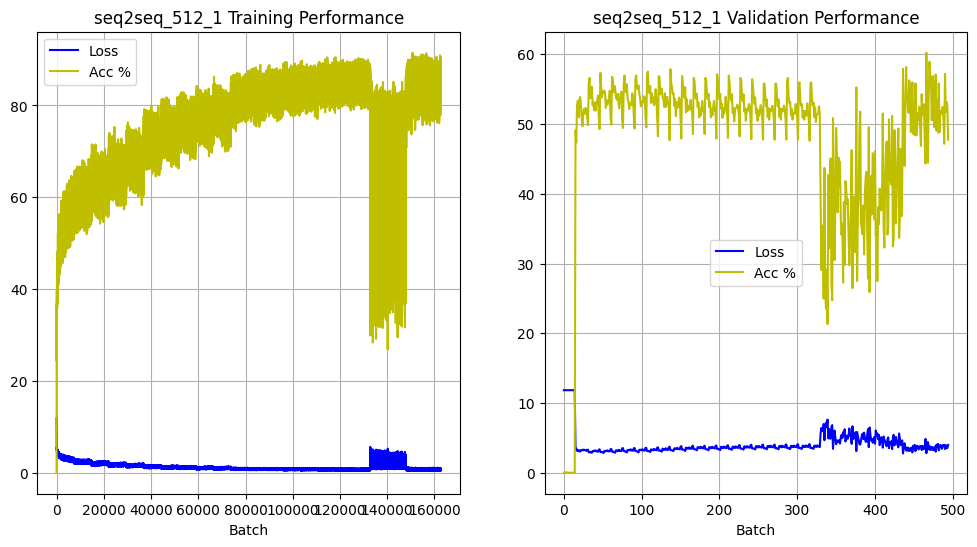

In [76]:
plot_train_and_valid_stats()

# **Insights from Training Performance**

From the plots shown above, it is clear that the model does improve over time at its' accuracy on the training set. There is a very steep increase in loss for the epoch with teacher forcing at 0.5 (50% active), this epoch was spent with the model trying to end sentences correctly without knowing the length of the output, and also making predictions without the output tokens being fed into the deocder.

With the current number of epochs, the learning stays steady at around 84% accuracy on the training set. I believe for a higher result, the model may need to be trained for 30+ more epochs at lower learning rates. From teh results, it seems the model's accuracy was impacted heavily by the number of epochs, seen by the sudden increases in accuracy (which remain for the rest of said epoch) at the beginning of each epoch.

# **Investigating the Errors**

One way I have decided to gain insight into what the mdoel is doing incorrectly is to log each time the model predicted a token incorrectly. The following code simply keeps a count of the total number of times any given token was predicted incorrectly in the validation set.

In [29]:
model.eval()
model = model.to(torch.device("cuda"))

wrongs = defaultdict(int)

with torch.no_grad():
    dataloader_valid = DataLoader(dataset=dataset_valid, batch_size=1, shuffle=False, collate_fn=ENGtoID.collate_fn)
    pbar = tqdm(dataloader_valid)
    for i, batch in enumerate(pbar):
        x, y, x_l, _ = batch
        x = x.to(torch.device("cuda"))
        out = model(x, x_l, y).argmax(dim=-1).flatten().tolist()
        #print(out)

        for a, b in zip(out, y.flatten().tolist()):
            if a == b:
                wrongs[a] += 1

100%|██████████| 1873/1873 [00:08<00:00, 213.42it/s]


From the output below, it is clear that the model most commonly predicted '.' and \<EOS\> incorrectly. This may be partly impacted by the tokenization/encoding system I implemented. It is clear the model found it difficult to end sentences appropriately as well. However, these insights are somewhat incomplete, as there are many ways to write a sentence in any given language. The remaining words on the list are very common works such as "I", "Will", "And", "That", "No",  "You", which also have many different usages. Given the popularity of the words, it may be that the count shows these mostly due to the frequency. Overall from this basic analysis, it is clear that the model struggled with punctuation and other symbols. This could also be due to their appearances in the training set, it is possible that my filter function, which should remove bad data, did not remove some and many entries ended up in the training set with unusual symbol usage.

In [44]:
wrongs_sorted = sorted(wrongs.items(), key=lambda item: item[1], reverse=True)

for k, v in wrongs_sorted[:20]:
    print(coder_id.decode([k])[0], "\t:", v)

. 	: 512
<EOS> 	: 447
, 	: 223
Aku 	: 93
- 	: 70
? 	: 66
aku 	: 40
akan 	: 37
! 	: 37
kau 	: 32
tidak 	: 30
Dan 	: 28
yang 	: 27
di 	: 20
kita 	: 20
ini 	: 19
" 	: 18
dia 	: 17
dan 	: 17
tahu 	: 16


# **Example Model Usage**

Below is an example of using the model to perform translations. The translations from the test input are somewhat accurate. From testing, it is clear they are actually affected by grammar, capital letters, punctuation etc. This may show the limitations of the tokenization/index encoding implementation. I believe with a more sophisticated training schedule, the model could perform quite well.

In [49]:
def play_model(text: str):
    text = tokenize_english(text) # tokenize the input
    text = coder_eng.encode(text) # turn tokens to indices
    text = torch.tensor(text).unsqueeze(dim=0) # convert to tensor
    out = model(text, torch.tensor([text.shape[-1]]), None).argmax(dim=-1).flatten().tolist() # get prediction, convert to list
    out = coder_id.decode(out) # decode the prediction (indices)
    return ' '.join(out[:-1]) # return as a string

In [75]:
# run translation
model.eval()
with torch.no_grad():
    
    model = model.to(torch.device("cpu"))
    print(play_model("Are you my friend?")) # my friend? (somewhat correct)
    print(play_model("what day is it today")) # life today (not correct)
    print(play_model("I can speak English")) # can speak English (missing context)
    print(play_model("he is over there.")) # he is there (correct translation)
    print(play_model("Please take my money.")) # take my money (slightly incorrect)
    print(play_model("There are lots of ways to say things.")) # many things to say (misinterpreted)
    print(play_model("that car is red")) # that red car (misinterpreted meaning)

teman ku ?
nyawa hari ini .
bisa bahasa Inggris .
dia di sana . . .
mengambil uang saya .
Banyak hal yang harus dikatakan .
merah mobil itu .


# **Project Evaluation/Improvements**

**Preprocessing**
To improve this model/project I would first focus on a better tokenization system. Byte pair encoding or something similar may be a much greater improvement over my implementation. Using a more complex encoding system may also yield better results for things like grammar generation. The way the project is setup currently, space characters (' ') do not exist. Each token is separated by spaces. Another way I would consider improving is in the dataset, where I would try to increase the size of the valid set, or decrease the size of the training set. My implementation of getting rid of unusable data is crude, only using regex pattern matching. This removes only a few samples relative to the size of the dataset, but from my testing seemed to do the job reasonably well, mainly focusing on removing samples with certain symbols occuring and invalid grammar such as links. When creating the vocabulary, the only tokens that are saved are the ones present in the training set. The validation set does actually contain tokens that are not present, but for the sake of a proper training loop, the model is only trained on what is present in the training set. This may indicate flaws in the dataset split and could be investigated/improved further.

**Training**
To improve this project further, I would focus on the training hyper paramter sequence. I would look to do more manual-finetuning, such as running the model on a subset of the training set where it had the highest loss. I would run the model on these data entries with a lower learning rate as to not disturb its' accuracy on other data. Since this is a large task, I believe running the model on 25-30 epochs is definitely not enough. Many established models such as YOLO can be expected to train on hundreds of epochs, and they may have only a few thousand classes to predict. This model has over 130,000 classes to predict (each token) for each timestep t in the output sequence, so the actual performance of the model may be greatly increased if the training is stretched to 50+ epochs at a low learning rate. Throughout this project I did notice significant jumps in accuracy at the beginning of each epoch, which may further illustrate the impact that numerous epochs can have on the model's performance. If given more time and access to higher compute without a large cost, to train the model with more combinations of hyper parameters, notably the teacher forcing would be a place of curiosity.

**Validation**
I would also try to log more interesting metrics such as the bleu score, however this would most likely require a much more comprehensive dataset with reference tokens, etc, to be accurate. Running the model on the validation with more logging would be an improvement too, whereas you may log the tokens it predicted incorrectly, and what they should have been.

**Model**
The model I decided to implement is a basic sequence to sequence LSTM model, however I believe a more complex model such as a transformer or try a similar complexity model such as a GRU. At the beginning stages of the project I tried to use the current LSTM model with 2 layers (instead of 1) and a lower hidden size of 256. My decision to use the current sized model is that the dataset is significantly large at almost 1 million samples, and would prefer the higher weight count (200 million approx.) to be able to encode this data.

In [ ]:
%tensorboard